In [1]:
import os
import textwrap
import tiktoken
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from dotenv import load_dotenv, find_dotenv
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from langchain import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from typing import Optional

In [2]:
load_dotenv(find_dotenv())
embeddings = OpenAIEmbeddings()

detailed_turbo_llm = turbo_llm = ChatOpenAI(
    temperature=0.9,
    model_name='gpt-3.5-turbo-0125'
)

turbo_llm = ChatOpenAI(
    temperature=0.7,
    model_name='gpt-3.5-turbo-0125'
)

In [3]:
# Carga de documentos y extracción de información
# (asegúrate de que haya PDFs en la carpeta documentos)
documents = DirectoryLoader('./documentos/', glob="./*.pdf", loader_cls=PyPDFLoader).load()
# Tratameinto de caracteres indeseados
for d in documents:
    d.page_content = d.page_content.replace('\n', ' ').replace('\t', ' ')
# Separador de texto (límita el texto para que sea soportado por el LLM)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=500
)
docs = text_splitter.split_documents(documents)
texts = [doc.page_content for doc in docs]

In [4]:
def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

counts = [num_tokens_from_string(t) for t in texts]

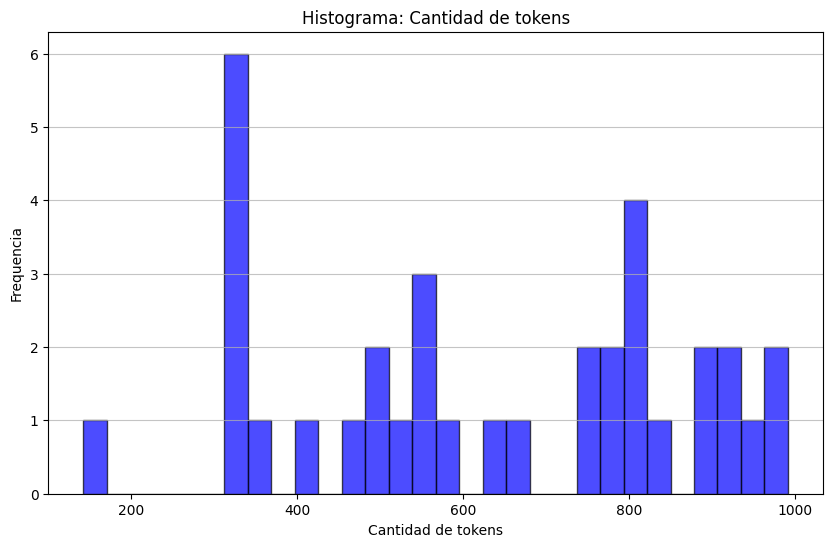

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histograma: Cantidad de tokens")
plt.xlabel("Cantidad de tokens")
plt.ylabel("Frequencia")
plt.grid(axis="y", alpha=0.75)
plt.show()

In [6]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 22157


In [7]:
global_embeddings = [embeddings.embed_query(txt) for txt in texts]

In [8]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)

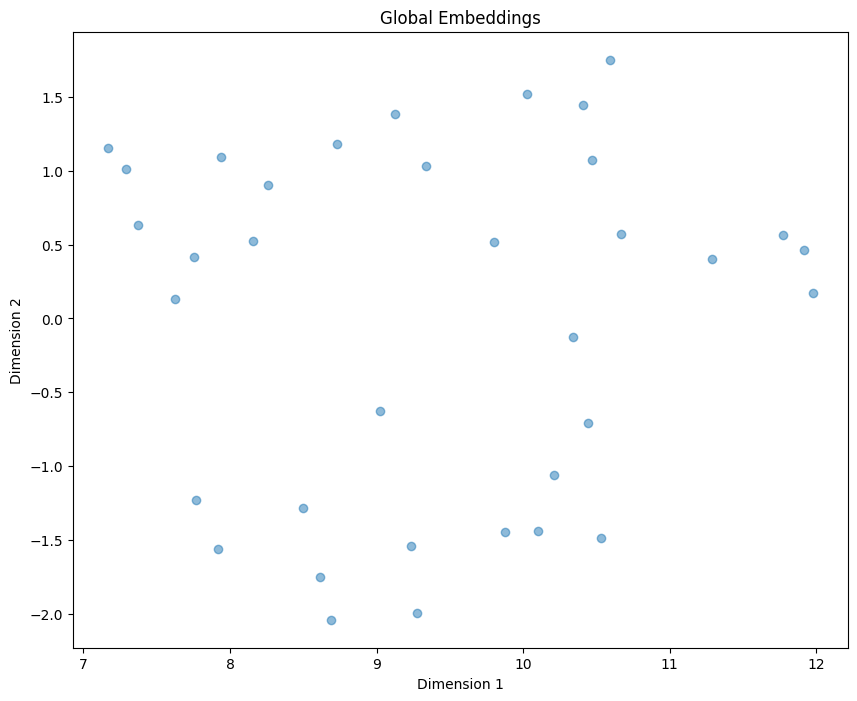

In [9]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


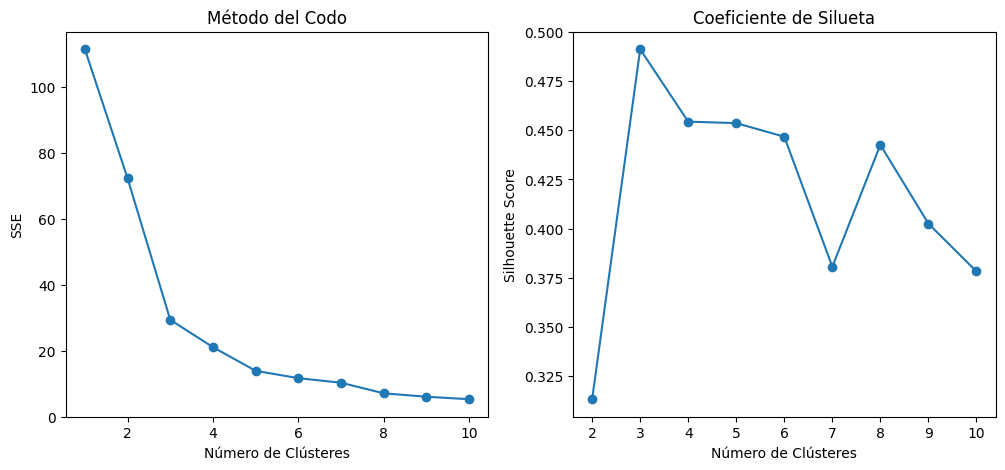

In [10]:
# Método del Codo
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    sse.append(kmeans.inertia_)

# Coeficiente de Silueta
silhouette_scores = []
for k in k_values[1:]:  # Silhouette score no está definido para k=1
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    score = silhouette_score(global_embeddings_reduced, kmeans.labels_)
    silhouette_scores.append(score)

# Graficar el método del codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('SSE')

# Graficar el coeficiente de silueta
plt.subplot(1, 2, 2)
plt.plot(k_values[1:], silhouette_scores, marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clústeres')
plt.ylabel('Silhouette Score')

plt.show()

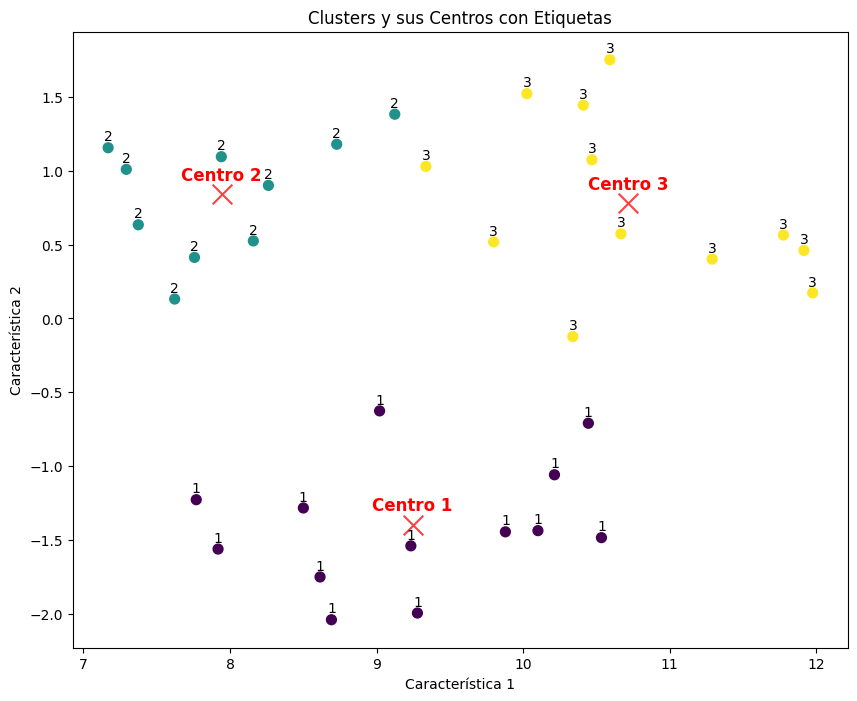

In [12]:
# Suponiendo que 'global_embeddings_reduced' ya está definido
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(global_embeddings_reduced)
labels = kmeans.labels_ + 1  # Agregar 1 a las etiquetas de los clústeres
centers = kmeans.cluster_centers_

# Visualizar los datos y los centros de los clústeres
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')

# Añadir etiquetas a los puntos de datos
for i in range(len(global_embeddings_reduced)):
    plt.annotate(str(labels[i]), (global_embeddings_reduced[i, 0], global_embeddings_reduced[i, 1]),
                 textcoords="offset points", xytext=(0,5), ha='center')

# Añadir etiquetas a los centros de los clústeres
for i, center in enumerate(centers):
    plt.annotate(f'Centro {i+1}', (center[0], center[1]), textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=12, weight='bold')

plt.title("Clusters y sus Centros con Etiquetas")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

In [13]:
df = pd.DataFrame({
    'Texto': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': labels
})
df.head()

,Texto,Embedding,Cluster
0,Depósito legal ppi 201502ZU4662 Esta publicaci...,"[7.918428, -1.5600123]",1
1,Disponible en: https://produccioncientificaluz...,"[10.591878, 1.7498543]",3
2,108Licencia de Creative Commons Atribución 4....,"[10.41059, 1.4423863]",3
3,"la obtención de ganancias, siendo una condici...","[8.614387, -1.748587]",1
4,"109 Revista de Ciencias Sociales, Vol. XXIX, N...","[8.500419, -1.2819436]",1


In [14]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Texto'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

clustered_texts = format_cluster_texts(df)
clustered_texts

{1: 'Depósito legal ppi 201502ZU4662 Esta publicación científica en formato digital es continuidad de la revista impresa Depósito Legal: pp 197402ZU789 ● ISSN: 1315-9518 ● ISSN-E: 2477-9431 Esta publicación científica en formato digital es continuidad de la revista impresa Depósito Legal: pp 197402ZU789 ISSN: 1315-9518Universidad del Zulia. Revista de la Facultad de Ciencias Económicas y Sociales Vol. XXIX, No. 4                                                    OCTUBRE-DICIEMBRE 2023 --- la obtención de ganancias, siendo  una condición tecnológica inherente a todos  los problemas de eficiencia y eficacia (Caird,  1992; Campo-Ternera et al., 2018; Velázquez, Cruz y Vargas, 2018; Vega, Bautista y  Martínez, 2020; Medina y Espinosa, 2022).  Por su parte, Albornoz (2009), lo describe  como la búsqueda de mejores condiciones  competitivas desde las empresas a través de  la investigación básica y la tecnología. Es así  que la innovación se compone de una serie  de actividades, no solamente

# Hay que volver a hacer un split de texto para solucionar problemas de capacidad en el LLM.

In [15]:
template = """Eres un asistente capaz de crear resúmenes detallados del texto proporcionado.

Texto:
{text}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | detailed_turbo_llm | StrOutputParser()

In [16]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

summaries

{1: 'El texto proporciona información sobre la importancia de la innovación en las pequeñas y medianas empresas (pyme) y su impacto en diferentes sectores económicos en todo el mundo. Se abordan temas como la obtención de ganancias a través de la eficiencia y eficacia, la innovación como búsqueda de mejores condiciones competitivas, y el análisis de redes sociales en relación con la innovación.\n\nSe destacan estudios que relacionan la innovación en las pyme con el desempeño, el empleo y el desarrollo de modelos de ventajas competitivas en diferentes países. Se examina cómo factores como la gestión del riesgo, la sustentabilidad, la eficiencia y la capacidad organizacional afectan el desempeño de las empresas. También se analiza la relevancia de la innovación incremental como un punto de inflexión en el desempeño de las empresas, tanto pequeñas como grandes.\n\nSe utilizan diferentes técnicas, como el análisis de redes sociales, estudios de caso, modelos de ecuaciones estructurales y e

In [17]:
clustered_summaries = {}
for label, summary in zip(labels, summaries.values()):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(summary)

clustered_summaries

{1: ['El texto proporciona información sobre la importancia de la innovación en las pequeñas y medianas empresas (pyme) y su impacto en diferentes sectores económicos en todo el mundo. Se abordan temas como la obtención de ganancias a través de la eficiencia y eficacia, la innovación como búsqueda de mejores condiciones competitivas, y el análisis de redes sociales en relación con la innovación.\n\nSe destacan estudios que relacionan la innovación en las pyme con el desempeño, el empleo y el desarrollo de modelos de ventajas competitivas en diferentes países. Se examina cómo factores como la gestión del riesgo, la sustentabilidad, la eficiencia y la capacidad organizacional afectan el desempeño de las empresas. También se analiza la relevancia de la innovación incremental como un punto de inflexión en el desempeño de las empresas, tanto pequeñas como grandes.\n\nSe utilizan diferentes técnicas, como el análisis de redes sociales, estudios de caso, modelos de ecuaciones estructurales y 

In [18]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

final_summaries

{1: 'El texto destaca la importancia de la innovación en las pequeñas y medianas empresas (pyme) y su impacto en diversos sectores económicos a nivel mundial. Se menciona la obtención de ganancias a través de la eficiencia y eficacia, la búsqueda de mejores condiciones competitivas a través de la innovación, y el análisis de redes sociales en relación con la innovación.\n\nSe resaltan estudios que vinculan la innovación en las pyme con el desempeño, el empleo y el desarrollo de modelos de ventajas competitivas en diferentes países. Se analizan factores como la gestión del riesgo, la sustentabilidad, la eficiencia y la capacidad organizacional en el rendimiento de las empresas. Se subraya la importancia de la innovación incremental como un factor clave en el desempeño de las empresas.\n\nSe emplean diversas técnicas, como el análisis de redes sociales, estudios de caso, modelos de ecuaciones estructurales y entrevistas a expertos, para comprender mejor la innovación en las pyme. Se dest

In [19]:
texts_from_df = df['Texto'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

### 1. Enseñar

In [20]:
persist_directory = input('¿Cómo se llama este knoledge-base?: ') + '_kb'
vectorstore = Chroma.from_texts(texts=combined_texts,
                                embedding=embeddings,
                                persist_directory=persist_directory)
vectorstore.persist()
vectorstore = None
os.system(f'zip -r db.zip ./{persist_directory}')

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


1

### 2. Recordar (si y solo si Enseñar=Done) y pregunta de control

In [21]:
persist_directory = input('¿Qué knoledge-base deseas usar?: ') + '_kb'
embedding = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)

def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.invoke(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("¿Cuál es el tema pricipal del documento?", 10000, 4)
print(final_number)
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

8


In [22]:
# Se personaliza el LLM
template = """
Eres Prometeo, un asistente personal de revisión biliográfica que habla Español.

Tu tarea consiste en:

1. Leer detalladamente la información proporcionada en documentos que generalmente son
artículos científicos en formato PDF.

2. Ser capaz de dar respuestas a cualquier tipo de pregunta relacionada con el contexto, 
en especial a preguntas puntuales.

3. Ser carismático y ofrecer información sobre ti y tus funciones.

SIEMPRE debes responder con base al contexto proporcionado aqui: {context}.
        
Si no sabes la respuesta, puedes decir: 'No sé'.

NUNCA hables específicamente del contexto.

Teniendo lo anterior en cuenta, responde la siguiente pregunta: {question}
"""

prometeo_prompt = PromptTemplate(
    template=template, input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prometeo_prompt
    | turbo_llm
    | StrOutputParser()
)

In [23]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

¿Cuáles son los enfoques usados en la investigación?
Los enfoques utilizados en la investigación son principalmente
cuantitativos y cualitativos. En Europa y Asia se destacan los
enfoques cuantitativos, mientras que en América se observa un enfoque
cualitativo predominante.


In [24]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

¿Quién o quiénes son los autores del documento?
Los autores del documento son Karla Rodríguez-Burgos y Carlos F.
Miranda-Medina.
